In [1]:
WEB_SITE_matrix = '../../models/downloadplus.org/view_matrix/lil_matrix.npz'
WEB_SITE_itemindexer = '../../models/downloadplus.org/view_matrix/item_indexer.indexer'
WEB_SITE_userindexer = '../../models/downloadplus.org/view_matrix/user_indexer.indexer'
SAVING1 = './alisResult/paroshat/ALS/ali_item_indexer_factorized.indexer'
SAVING2 = './alisResult/paroshat/ALS/ali_user_indexer_factorized.indexer'
SAVING3 = './alisResult/paroshat/ALS/ali_items_vectors.npy'
SAVING4 = './alisResult/paroshat/ALS/ali_users_vectors.npy'
WEB_SITE_NAME = 'Downloadplus.org'
RESULTS = '/home/yektanet/Pictures/ALSOptDownloadPlus/'
TEST_SET_SIZE = 0.62 # max = 1
TEST_SET_SIZE1 = 0.59 # max = 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math
from sklearn.model_selection import train_test_split
# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix
import scipy
import scipy.sparse
import itertools
import random

In [3]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load(WEB_SITE_itemindexer)
        self.user_indexer = AppendIndexer.load(WEB_SITE_userindexer)
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [4]:
def ALSReady(path: str, l = 2):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = l, 
                      item_min_view = l)
    implicit_matrix = matrix.to_csr()
    print('matrix has been made dense in', time.time() - now, 'seconds.')
    return matrix, sparce_matrix, implicit_matrix

def CFTrain(matrix, implicit_matrix, _alpha = 15, _facs = 20, _itr = 15, save = False):
    
    now = time.time()
    als_model = ALS.Als(num_factors = _facs,
                        iterations = _itr,
                        num_threads = 10,
                        alpha = _alpha)

    
    als_model.fit(implicit_matrix)
    alsTime = time.time() - now
    print('ALS model is fitted in', alsTime, 'seconds.')
    if save:
        print('Saving Data ...')
        matrix.item_indexer.dump(SAVING1)
        matrix.user_indexer.dump(SAVING2)
        np.save(SAVING3, als_model.item_vectors)
        np.save(SAVING4, als_model.user_vectors)

    return als_model.item_vectors, als_model.user_vectors, alsTime

In [5]:
def get_annoy_results(pages_vector, number_of_trees = 50, number_of_neighbours = 11):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

implicit matrix ro migire va ye bakhshisho baramun test o train mikone ke ye bakhshi az cell ha sefr shodan:

In [6]:
def generate_test_set_precision_recall(implicit_matrix, _test_size = 0.05, test_cells = 0.2):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows,cols = test.nonzero()
    delete_index = [(rows[i], cols[i]) for i in random.sample(range(1, len(rows)), int(len(rows)*test_cells))]
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in tqdm(zip(rows, cols)):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_AP(implicit_matrix, _test_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = _test_size)
    print('test_shape', test.shape, 'train_shape (which we cant process bc of RAM)', train.shape)
    rows, cols = test.nonzero()
    unique, counts = np.unique(rows, return_counts=True)
    commulative_count = [0]
    for i in counts:
        commulative_count.append(commulative_count[-1] + i)
    delete_row = []
    for i in range(1, len(commulative_count)):
        delete_row.append(np.random.randint(commulative_count[i-1], commulative_count[i]))
    delete_index = [(rows[i], cols[i]) for i in delete_row]
    # print(delete_row[:10], delete_index[:10], rows[:10], cols[:10], random.randrange(commulative_count[0], 10, 2) )
    print("total cells", len(rows), "number of deleted cells", len(delete_index))
    
    x_train = scipy.sparse.csr_matrix(test.shape)
    for i, j in zip(rows, cols):
        if (i, j) in delete_index:
            continue
        x_train[i, j] = test[i, j]
    return x_train, test, delete_index

def prepare_data_for_MAE(implicit_matrix, set_size = 0.05):
    train, test = train_test_split(implicit_matrix, shuffle=False, test_size = set_size)
    return test

In [7]:
def hit_rate_at_k(deleted, x_train, test_approx, k = 10):
    found = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], 30))
        nonz = np.nonzero(x_train[i])[0]
        same_old = []
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)

        for l in same_old[::-1]:
            ta.pop(l)
        ta = ta[:k]        
        for j in ta:
            found.append((i, j))
    same = 0
    a = np.array([hash(i) for i in found])
    b = np.array([hash(i) for i in deleted])
    same = np.sum(np.isin(b,a))
    print(same, len(deleted), same/len(deleted))
    return same/len(deleted)

def visited_at_k(x_train, test_approx, k = 10):
    same_old = []
    for i in tqdm(range(len(test_approx))):
        ta = list(n_argmax(test_approx[i], k))
        nonz = np.nonzero(x_train[i])[0]
        for l in range(len(ta)):
            if ta[l] in nonz:
                same_old.append(l)
    rows,cols = x_train.nonzero()
    return len(same_old)/len(rows)

def n_argmax(a, n):
    ranked = np.argsort(a)
    largest_indices = ranked[::-1][:n]
    return largest_indices

In [8]:
#random search
itrs1 = [15, 15, 15, 15, 15, 15]
alphas1 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
factors1 = [5, 10, 20, 40, 60, 100]

itrs2 = [15, 15, 15, 15, 15, 15]
alphas2 = [10, 10, 10, 10, 10, 10]
factors2 = [5, 10, 20, 40, 60, 100]

itrs3 = [15, 15, 15, 15, 15, 15]
alphas3 = [100, 100, 100, 100, 100, 100]
factors3 = [5, 10, 20, 40, 60, 100]

itrs4 = [15, 15, 15, 15, 15, 15]
alphas4 = [1000, 1000, 1000, 1000, 1000, 1000]
factors4 = [5, 10, 20, 40, 60, 100]

itrs = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
alphas = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 100, 1000, 1000, 1000, 1000, 1000, 1000]
factors = [5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100, 5, 10, 20, 40, 60, 100]

### metrics

accuracy metrics:
- recall@k, hit_rate@k
- visited_rate@k
- MAE on train set per iteration

time metrics:
- training time
- query time

In [9]:
def calc_visited_hitRate(alphas, itrs, factors, _l = 2, data_set_size = 0.072, log = False):
    visited3s = []
    hitRate3s = []
    visited6s = []
    hitRate6s = []
    AP3s = []
    AP6s = []
    trainingTime = []
    qTime = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    x_train_AP, test_AP, delete_index_AP = prepare_data_for_AP(implicit_matrix, _test_size = data_set_size)
    x_train, test, deleted = generate_test_set_precision_recall(implicit_matrix, _test_size = data_set_size)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors------', a,i,f)
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, x_train, _alpha = a, _facs = f, _itr = i)
        a1, a2, duration = get_annoy_results(item_vectors)
        qTime.append(duration)
        trainingTime.append(alsTime)
        if log: print('training and querry time:', trainingTime[-1], qTime[-1])
        test_approx = np.matmul(user_vectors, item_vectors.T)
        visited3s.append(visited_at_k(x_train.toarray(), test_approx, k = 3))
        if log: print('visited3s', visited3s[-1])
        visited6s.append(visited_at_k(x_train.toarray(), test_approx, k = 6))
        if log: print('visited6s', visited6s[-1])
        hitRate3s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 3))
        if log: print('hitRate3s', hitRate3s[-1])
        hitRate6s.append(hit_rate_at_k(deleted, x_train.toarray(), test_approx, k = 6))
        if log: print('hitRate6s', hitRate6s[-1])
        item_vectors_AP, user_vectors_AP, alsTime_AP = \
        CFTrain(None, x_train_AP, _alpha = a, _facs = f, _itr = i)
        test_approx_AP = np.matmul(user_vectors_AP, item_vectors_AP.T)
        AP3s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 3))
        if log: print('AP3s', AP3s[-1])
        AP6s.append(hit_rate_at_k(delete_index_AP, x_train_AP, test_approx_AP, k = 6))
        if log: print('AP6s', AP6s[-1])
    return visited3s, visited6s, hitRate3s, hitRate6s, AP3s, AP6s, trainingTime, qTime

In [10]:
def calc_mse__(alphas, itrs, factors, _l = 3, data_set_size = 0.072, log = False):
    mse = []
    matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=_l)
    train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.06)
    for a,i,f in zip(alphas, itrs, factors):
        if log: print('------alphas, itrs, factors:', a,i,f, '------')
        item_vectors, user_vectors, alsTime = \
        CFTrain(None, train, _alpha = a, _facs = f, _itr = i)
        test_approx = np.matmul(user_vectors, item_vectors.T)
        mse.append(MSE(test_approx, train))
        print('MSE', mse[-1])
    return mse

In [11]:
def MAE(approx, train):
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE(approx, train):
    absolute_error = np.absolute(train - approx)
    absolute_error = np.square(absolute_error)
    return np.mean(absolute_error)
def MAE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 10, _facs = 20, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    absolute_error = np.absolute(train - approximated_matrix)
    return np.mean(absolute_error)
def MSE_calc(train, itr = 10, facs = 20):
    item_vectors, user_vectors, alsTime = \
    CFTrain(None, train, _alpha = 100, _facs = 25, _itr = itr)
    approximated_matrix = np.matmul(user_vectors, item_vectors.T)
    return MSE(approximated_matrix, train)

In [12]:
matrix, sparce_matrix, implicit_matrix = ALSReady(WEB_SITE_matrix, l=2)
MSEs = []
train, test = train_test_split(implicit_matrix, shuffle=False, train_size = 0.08)
for i in [i for i in range(20)]:
    MSEs.append(MSE_calc(train, itr = i))
    print(MSEs[-1])

View matrix loaded in 0.6351213455200195 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.5180413722991943 seconds.
ALS model is fitted in 0.0034666061401367188 seconds.
25.31880827250719
ALS model is fitted in 0.03934431076049805 seconds.
0.014544485599105388
ALS model is fitted in 0.05471658706665039 seconds.
0.012547124854700066
ALS model is fitted in 0.09521937370300293 seconds.
0.012034580036112201
ALS model is fitted in 0.12405085563659668 seconds.
0.011738740815751627
ALS model is fitted in 0.1594550609588623 seconds.
0.011626054406859598
ALS model is fitted

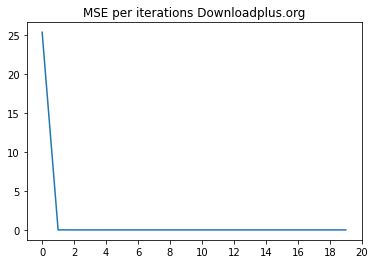

In [13]:
X = [i for i in range(20)]
plt.plot(X, MSEs)
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(0, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs1_' + WEB_SITE_NAME + '.png', dpi=400)

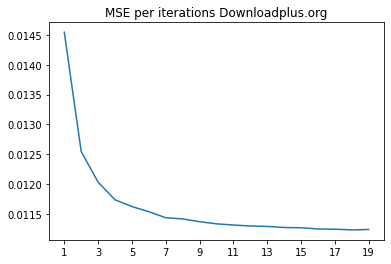

In [14]:
X = [i for i in range(1, 20)]
plt.plot(X, MSEs[1:])
plt.title("MSE per iterations " + WEB_SITE_NAME)
plt.xticks(np.arange(1, len(X)+1, 2))
plt.savefig(RESULTS + 'MSE_per_itrs2_' + WEB_SITE_NAME + '.png', dpi=400)

## Run on all

In [15]:
MSEs = []
visited3s = []
visited6s = []
hitRate3s = []
hitRate6s = []
AP3s = []
AP6s = []
trainingTime = []
qTime = []

In [16]:
visited3s1, visited6s1, hitRate3s1, hitRate6s1, AP3s1, AP6s1, trainingTime1, qTime1 = \
calc_visited_hitRate(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE1 = calc_mse__(alphas1, itrs1, factors1, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE1)
visited3s.append(visited3s1)
visited6s.append(visited6s1)
hitRate3s.append(hitRate3s1)
hitRate6s.append(hitRate6s1)
AP3s.append(AP3s1)
AP6s.append(AP6s1)
trainingTime.append(trainingTime1)
qTime.append(qTime1)

View matrix loaded in 0.7837047576904297 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.469412088394165 seconds.
test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 20924


/home/yektanet/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
128it [00:00, 1274.10it/s]

test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 9593


47966it [00:52, 917.17it/s] 


------alphas, itrs, factors------ 0.1 15 5
ALS model is fitted in 0.58174729347229 seconds.
annoy time: 0.14146065711975098
training and querry time: 0.58174729347229 0.14146065711975098


  7%|▋         | 1466/20924 [00:00<00:01, 14659.00it/s]

visited3s 0.2838975321189378


  3%|▎         | 700/20924 [00:00<00:02, 6991.59it/s]

visited6s 0.322935397284549


  3%|▎         | 706/20924 [00:00<00:02, 7058.31it/s]

2429 9593 0.2532054623162723
hitRate3s 0.2532054623162723


100%|██████████| 20924/20924 [00:03<00:00, 6950.76it/s]


2627 9593 0.2738455123527572
hitRate6s 0.2738455123527572


  1%|          | 127/20924 [00:00<00:16, 1268.75it/s]

ALS model is fitted in 0.5722179412841797 seconds.


  1%|▏         | 276/20924 [00:00<00:07, 2759.38it/s]

3813 20924 0.18223093098833876
AP3s 0.18223093098833876


100%|██████████| 20924/20924 [00:06<00:00, 3122.03it/s]


4343 20924 0.2075606958516536
AP6s 0.2075606958516536
------alphas, itrs, factors------ 0.1 15 10
ALS model is fitted in 0.9025235176086426 seconds.
annoy time: 0.1586751937866211
training and querry time: 0.9025235176086426 0.1586751937866211


  7%|▋         | 1455/20924 [00:00<00:01, 14543.63it/s]

visited3s 0.398769968467412


  3%|▎         | 674/20924 [00:00<00:03, 6732.75it/s]

visited6s 0.45373048758241474


  3%|▎         | 705/20924 [00:00<00:02, 7047.35it/s]

2727 9593 0.2842697800479516
hitRate3s 0.2842697800479516


100%|██████████| 20924/20924 [00:03<00:00, 6795.21it/s]


3101 9593 0.32325654122797876
hitRate6s 0.32325654122797876


  1%|          | 140/20924 [00:00<00:14, 1399.79it/s]

ALS model is fitted in 0.8099038600921631 seconds.


  1%|          | 254/20924 [00:00<00:08, 2537.58it/s]

4707 20924 0.22495698719174154
AP3s 0.22495698719174154


100%|██████████| 20924/20924 [00:07<00:00, 2710.18it/s]


5624 20924 0.26878225960619384
AP6s 0.26878225960619384
------alphas, itrs, factors------ 0.1 15 20
ALS model is fitted in 1.331751823425293 seconds.
annoy time: 0.1281135082244873
training and querry time: 1.331751823425293 0.1281135082244873


  7%|▋         | 1434/20924 [00:00<00:01, 14334.14it/s]

visited3s 0.5650587652776692


  3%|▎         | 708/20924 [00:00<00:02, 7076.48it/s]

visited6s 0.6241367628280301


  3%|▎         | 712/20924 [00:00<00:02, 7113.88it/s]

3778 9593 0.3938288335244449
hitRate3s 0.3938288335244449


100%|██████████| 20924/20924 [00:02<00:00, 7132.03it/s]


4079 9593 0.4252058792869801
hitRate6s 0.4252058792869801


  1%|          | 130/20924 [00:00<00:16, 1298.00it/s]

ALS model is fitted in 1.1029689311981201 seconds.


  1%|▏         | 293/20924 [00:00<00:07, 2927.37it/s]

5663 20924 0.2706461479640604
AP3s 0.2706461479640604


100%|██████████| 20924/20924 [00:07<00:00, 2828.91it/s]


6652 20924 0.3179124450391895
AP6s 0.3179124450391895
------alphas, itrs, factors------ 0.1 15 40
ALS model is fitted in 7.499608278274536 seconds.
annoy time: 0.14603638648986816
training and querry time: 7.499608278274536 0.14603638648986816


  7%|▋         | 1527/20924 [00:00<00:01, 15268.01it/s]

visited3s 0.67054960519115


  3%|▎         | 713/20924 [00:00<00:02, 7124.72it/s]

visited6s 0.7192557266828239


  3%|▎         | 610/20924 [00:00<00:03, 6090.99it/s]

2657 9593 0.2769727926613155
hitRate3s 0.2769727926613155


100%|██████████| 20924/20924 [00:03<00:00, 5934.98it/s]


2987 9593 0.3113728760554571
hitRate6s 0.3113728760554571


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 10.274397134780884 seconds.


  1%|▏         | 299/20924 [00:00<00:06, 2982.27it/s]

3827 20924 0.18290001911680367
AP3s 0.18290001911680367


100%|██████████| 20924/20924 [00:06<00:00, 3173.56it/s]


4708 20924 0.2250047792009176
AP6s 0.2250047792009176
------alphas, itrs, factors------ 0.1 15 60
ALS model is fitted in 12.409297227859497 seconds.
annoy time: 0.13294124603271484
training and querry time: 12.409297227859497 0.13294124603271484


  7%|▋         | 1447/20924 [00:00<00:01, 14466.15it/s]

visited3s 0.741146118364475


  3%|▎         | 715/20924 [00:00<00:02, 7142.65it/s]

visited6s 0.7841451020248612


  3%|▎         | 671/20924 [00:00<00:03, 6702.83it/s]

2431 9593 0.25341394767017617
hitRate3s 0.25341394767017617


100%|██████████| 20924/20924 [00:02<00:00, 7079.69it/s]


2649 9593 0.2761388512457
hitRate6s 0.2761388512457


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 11.725744247436523 seconds.


  2%|▏         | 314/20924 [00:00<00:06, 3136.91it/s]

3317 20924 0.15852609443701013
AP3s 0.15852609443701013


100%|██████████| 20924/20924 [00:06<00:00, 3166.55it/s]


4203 20924 0.2008698145670044
AP6s 0.2008698145670044
------alphas, itrs, factors------ 0.1 15 100
ALS model is fitted in 35.01816177368164 seconds.
annoy time: 0.13315081596374512
training and querry time: 35.01816177368164 0.13315081596374512


  7%|▋         | 1502/20924 [00:00<00:01, 15018.19it/s]

visited3s 0.8124462512704245


  3%|▎         | 690/20924 [00:00<00:02, 6894.06it/s]

visited6s 0.8514319964558413


  3%|▎         | 529/20924 [00:00<00:03, 5282.98it/s]

1422 9593 0.14823308662566453
hitRate3s 0.14823308662566453


100%|██████████| 20924/20924 [00:03<00:00, 6891.38it/s]


1717 9593 0.17898467632648807
hitRate6s 0.17898467632648807


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 44.0475435256958 seconds.


  1%|          | 210/20924 [00:00<00:09, 2094.01it/s]

1860 20924 0.08889313706748232
AP3s 0.08889313706748232


100%|██████████| 20924/20924 [00:11<00:00, 1864.12it/s]


2554 20924 0.12206079143567196
AP6s 0.12206079143567196
View matrix loaded in 0.6528036594390869 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.7186803817749023 seconds.
------alphas, itrs, factors: 0.1 15 5 ------
ALS model is fitted in 0.07499265670776367 seconds.
MSE 0.0033384019945252104
------alphas, itrs, factors: 0.1 15 10 ------
ALS model is fitted in 0.12084150314331055 seconds.
MSE 0.0026621555414167524
------alphas, itrs, factors: 0.1 15 20 ------
ALS model is fitted in 0.24867916107177734 seconds.
MSE 0.002151834009335732
------alphas, itrs, factors: 

In [17]:
visited3s2, visited6s2, hitRate3s2, hitRate6s2, AP3s2, AP6s2, trainingTime2, qTime2 = \
calc_visited_hitRate(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE2 = calc_mse__(alphas2, itrs2, factors2, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE2)
visited3s.append(visited3s2)
visited6s.append(visited6s2)
hitRate3s.append(hitRate3s2)
hitRate6s.append(hitRate6s2)
AP3s.append(AP3s2)
AP6s.append(AP6s2)
trainingTime.append(trainingTime2)
qTime.append(qTime2)

View matrix loaded in 0.655975341796875 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.596034288406372 seconds.
test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 20924


131it [00:00, 1309.22it/s]

test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 9593


47966it [00:48, 982.74it/s] 


------alphas, itrs, factors------ 10 15 5
ALS model is fitted in 0.6706023216247559 seconds.
annoy time: 0.1455216407775879
training and querry time: 0.6706023216247559 0.1455216407775879


  6%|▋         | 1335/20924 [00:00<00:01, 13347.18it/s]

visited3s 0.47624631902639875


  2%|▏         | 358/20924 [00:00<00:05, 3576.51it/s]

visited6s 0.624241002788419


  3%|▎         | 557/20924 [00:00<00:03, 5565.16it/s]

4224 9593 0.440321067445012
hitRate3s 0.440321067445012


100%|██████████| 20924/20924 [00:04<00:00, 4680.73it/s]


4920 9593 0.5128739706035651
hitRate6s 0.5128739706035651


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 0.6418602466583252 seconds.


  1%|          | 229/20924 [00:00<00:09, 2285.11it/s]

9657 20924 0.46152743261326706
AP3s 0.46152743261326706


100%|██████████| 20924/20924 [00:09<00:00, 2222.54it/s]


11831 20924 0.5654272605620341
AP6s 0.5654272605620341
------alphas, itrs, factors------ 10 15 10
ALS model is fitted in 0.8618438243865967 seconds.
annoy time: 0.10541129112243652
training and querry time: 0.8618438243865967 0.10541129112243652


  6%|▌         | 1231/20924 [00:00<00:01, 12303.03it/s]

visited3s 0.6380006775597425


  3%|▎         | 579/20924 [00:00<00:03, 5787.70it/s]

visited6s 0.739869178849712


  3%|▎         | 663/20924 [00:00<00:03, 6625.05it/s]

5291 9593 0.5515480037527364
hitRate3s 0.5515480037527364


100%|██████████| 20924/20924 [00:03<00:00, 6401.13it/s]


5862 9593 0.6110705722922964
hitRate6s 0.6110705722922964


  1%|          | 152/20924 [00:00<00:13, 1516.49it/s]

ALS model is fitted in 0.8696534633636475 seconds.


  1%|▏         | 293/20924 [00:00<00:07, 2926.83it/s]

12224 20924 0.5842095201682279
AP3s 0.5842095201682279


100%|██████████| 20924/20924 [00:06<00:00, 3056.91it/s]


14044 20924 0.6711909768686676
AP6s 0.6711909768686676
------alphas, itrs, factors------ 10 15 20
ALS model is fitted in 1.5216543674468994 seconds.
annoy time: 0.09565997123718262
training and querry time: 1.5216543674468994 0.09565997123718262


  7%|▋         | 1509/20924 [00:00<00:01, 15081.67it/s]

visited3s 0.775936205144242


  3%|▎         | 701/20924 [00:00<00:02, 7003.61it/s]

visited6s 0.8617256925442368


  3%|▎         | 723/20924 [00:00<00:02, 7225.20it/s]

6214 9593 0.6477639945793808
hitRate3s 0.6477639945793808


100%|██████████| 20924/20924 [00:02<00:00, 7029.75it/s]


6692 9593 0.6975919941624101
hitRate6s 0.6975919941624101


  1%|          | 124/20924 [00:00<00:16, 1236.28it/s]

ALS model is fitted in 1.1460399627685547 seconds.


  1%|▏         | 294/20924 [00:00<00:07, 2936.69it/s]

13865 20924 0.6626362072261518
AP3s 0.6626362072261518


100%|██████████| 20924/20924 [00:07<00:00, 2954.17it/s]


15730 20924 0.7517683043395145
AP6s 0.7517683043395145
------alphas, itrs, factors------ 10 15 40
ALS model is fitted in 9.732662677764893 seconds.
annoy time: 0.14154410362243652
training and querry time: 9.732662677764893 0.14154410362243652


  6%|▋         | 1330/20924 [00:00<00:01, 13292.69it/s]

visited3s 0.8626899121778334


  3%|▎         | 694/20924 [00:00<00:02, 6933.69it/s]

visited6s 0.9370130039350585


  4%|▎         | 742/20924 [00:00<00:02, 7419.05it/s]

6510 9593 0.6786198269571563
hitRate3s 0.6786198269571563


100%|██████████| 20924/20924 [00:02<00:00, 7386.59it/s]


6961 9593 0.725633274262483
hitRate6s 0.725633274262483


  1%|          | 168/20924 [00:00<00:12, 1676.65it/s]

ALS model is fitted in 7.0718834400177 seconds.


  1%|▏         | 307/20924 [00:00<00:06, 3061.38it/s]

10869 20924 0.5194513477346587
AP3s 0.5194513477346587


100%|██████████| 20924/20924 [00:06<00:00, 3113.04it/s]


13877 20924 0.6632097113362646
AP6s 0.6632097113362646
------alphas, itrs, factors------ 10 15 60
ALS model is fitted in 11.779067039489746 seconds.
annoy time: 0.11407876014709473
training and querry time: 11.779067039489746 0.11407876014709473


  7%|▋         | 1477/20924 [00:00<00:01, 14765.02it/s]

visited3s 0.9063143356005525


  3%|▎         | 723/20924 [00:00<00:02, 7224.82it/s]

visited6s 0.9666692726656764


  3%|▎         | 677/20924 [00:00<00:02, 6765.15it/s]

6477 9593 0.6751798186177421
hitRate3s 0.6751798186177421


100%|██████████| 20924/20924 [00:02<00:00, 7098.78it/s]


6938 9593 0.7232356926925884
hitRate6s 0.7232356926925884


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 12.062042713165283 seconds.


  2%|▏         | 317/20924 [00:00<00:06, 3163.70it/s]

8632 20924 0.41254062320779966
AP3s 0.41254062320779966


100%|██████████| 20924/20924 [00:06<00:00, 3017.07it/s]


11525 20924 0.5508029057541579
AP6s 0.5508029057541579
------alphas, itrs, factors------ 10 15 100
ALS model is fitted in 33.08919429779053 seconds.
annoy time: 0.11412692070007324
training and querry time: 33.08919429779053 0.11412692070007324


  7%|▋         | 1500/20924 [00:00<00:01, 14991.61it/s]

visited3s 0.9421207619941104


  3%|▎         | 693/20924 [00:00<00:02, 6922.32it/s]

visited6s 0.9855888254762463


  3%|▎         | 665/20924 [00:00<00:03, 6644.27it/s]

5956 9593 0.6208693839257792
hitRate3s 0.6208693839257792


100%|██████████| 20924/20924 [00:02<00:00, 7095.20it/s]


6667 9593 0.6949859272386115
hitRate6s 0.6949859272386115


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 33.71953272819519 seconds.


  3%|▎         | 649/20924 [00:00<00:06, 3260.18it/s]

6651 20924 0.3178646530300134
AP3s 0.3178646530300134


100%|██████████| 20924/20924 [00:06<00:00, 3249.64it/s]


8753 20924 0.41832345631810364
AP6s 0.41832345631810364
View matrix loaded in 0.5569455623626709 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.5504631996154785 seconds.
------alphas, itrs, factors: 10 15 5 ------
ALS model is fitted in 0.0682377815246582 seconds.
MSE 0.0065252776526363975
------alphas, itrs, factors: 10 15 10 ------
ALS model is fitted in 0.1147308349609375 seconds.
MSE 0.0057370117238494545
------alphas, itrs, factors: 10 15 20 ------
ALS model is fitted in 0.1564488410949707 seconds.
MSE 0.004564760108809514
------alphas, itrs, factors: 10 15 

In [18]:
visited3s3, visited6s3, hitRate3s3, hitRate6s3, AP3s3, AP6s3, trainingTime3, qTime3 = \
calc_visited_hitRate(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE3 = calc_mse__(alphas3, itrs3, factors3, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE3)
visited3s.append(visited3s3)
visited6s.append(visited6s3)
hitRate3s.append(hitRate3s3)
hitRate6s.append(hitRate6s3)
AP3s.append(AP3s3)
AP6s.append(AP6s3)
trainingTime.append(trainingTime3)
qTime.append(qTime3)

View matrix loaded in 0.5632004737854004 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.6304516792297363 seconds.
test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 20924


128it [00:00, 1275.07it/s]

test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 9593


47966it [00:44, 1080.89it/s]


------alphas, itrs, factors------ 100 15 5
ALS model is fitted in 0.568993330001831 seconds.
annoy time: 0.10844016075134277
training and querry time: 0.568993330001831 0.10844016075134277


  7%|▋         | 1496/20924 [00:00<00:01, 14953.56it/s]

visited3s 0.5763427409897585


  3%|▎         | 730/20924 [00:00<00:02, 7296.51it/s]

visited6s 0.6992677142782686


  3%|▎         | 631/20924 [00:00<00:03, 6304.53it/s]

4907 9593 0.5115188158031898
hitRate3s 0.5115188158031898


100%|██████████| 20924/20924 [00:02<00:00, 7109.98it/s]


5565 9593 0.580110497237569
hitRate6s 0.580110497237569


  1%|          | 151/20924 [00:00<00:13, 1506.78it/s]

ALS model is fitted in 0.5671510696411133 seconds.


  3%|▎         | 590/20924 [00:00<00:06, 2986.09it/s]

6135 20924 0.2932039762951634
AP3s 0.2932039762951634


100%|██████████| 20924/20924 [00:06<00:00, 3220.38it/s]


11231 20924 0.5367520550563946
AP6s 0.5367520550563946
------alphas, itrs, factors------ 100 15 10
ALS model is fitted in 0.8463723659515381 seconds.
annoy time: 0.1104276180267334
training and querry time: 0.8463723659515381 0.1104276180267334


  7%|▋         | 1510/20924 [00:00<00:01, 15097.75it/s]

visited3s 0.7409636984337946


  4%|▎         | 737/20924 [00:00<00:02, 7360.58it/s]

visited6s 0.8610741927918067


  4%|▎         | 739/20924 [00:00<00:02, 7384.16it/s]

6118 9593 0.6377566975919942
hitRate3s 0.6377566975919942


100%|██████████| 20924/20924 [00:02<00:00, 7115.26it/s]


6611 9593 0.6891483373293026
hitRate6s 0.6891483373293026


  1%|          | 126/20924 [00:00<00:16, 1256.87it/s]

ALS model is fitted in 0.8153038024902344 seconds.


  3%|▎         | 616/20924 [00:00<00:06, 3082.27it/s]

11335 20924 0.5417224240107054
AP3s 0.5417224240107054


100%|██████████| 20924/20924 [00:06<00:00, 3232.94it/s]


14208 20924 0.6790288663735423
AP6s 0.6790288663735423
------alphas, itrs, factors------ 100 15 20
ALS model is fitted in 1.2084286212921143 seconds.
annoy time: 0.07975649833679199
training and querry time: 1.2084286212921143 0.07975649833679199


  6%|▋         | 1310/20924 [00:00<00:01, 13092.27it/s]

visited3s 0.8433012795455138


  4%|▎         | 749/20924 [00:00<00:02, 7486.21it/s]

visited6s 0.9461340004690798


  3%|▎         | 702/20924 [00:00<00:02, 7014.57it/s]

6615 9593 0.6895653080371104
hitRate3s 0.6895653080371104


100%|██████████| 20924/20924 [00:03<00:00, 6684.39it/s]


7071 9593 0.737099968727197
hitRate6s 0.737099968727197


  1%|          | 132/20924 [00:00<00:15, 1316.32it/s]

ALS model is fitted in 1.113363265991211 seconds.


  1%|▏         | 307/20924 [00:00<00:06, 3061.49it/s]

13627 20924 0.6512617090422481
AP3s 0.6512617090422481


100%|██████████| 20924/20924 [00:06<00:00, 3254.79it/s]


15861 20924 0.758029057541579
AP6s 0.758029057541579
------alphas, itrs, factors------ 100 15 40
ALS model is fitted in 7.215578556060791 seconds.
annoy time: 0.10552859306335449
training and querry time: 7.215578556060791 0.10552859306335449


  7%|▋         | 1454/20924 [00:00<00:01, 14535.65it/s]

visited3s 0.9163734917780731


  4%|▎         | 743/20924 [00:00<00:02, 7422.27it/s]

visited6s 0.9866833450603288


  3%|▎         | 702/20924 [00:00<00:02, 7017.43it/s]

6768 9593 0.7055144376107578
hitRate3s 0.7055144376107578


100%|██████████| 20924/20924 [00:02<00:00, 7139.34it/s]


7243 9593 0.7550297091629313
hitRate6s 0.7550297091629313


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 8.174510717391968 seconds.


  3%|▎         | 649/20924 [00:00<00:06, 3256.21it/s]

13699 20924 0.6547027337029249
AP3s 0.6547027337029249


100%|██████████| 20924/20924 [00:06<00:00, 3243.57it/s]


16415 20924 0.7845058306251195
AP6s 0.7845058306251195
------alphas, itrs, factors------ 100 15 60
ALS model is fitted in 11.782660007476807 seconds.
annoy time: 0.11791777610778809
training and querry time: 11.782660007476807 0.11791777610778809


  7%|▋         | 1545/20924 [00:00<00:01, 15447.11it/s]

visited3s 0.9479842597659813


  4%|▎         | 734/20924 [00:00<00:02, 7336.60it/s]

visited6s 0.994371042139004


  3%|▎         | 701/20924 [00:00<00:02, 7008.70it/s]

6693 9593 0.697696236839362
hitRate3s 0.697696236839362


100%|██████████| 20924/20924 [00:02<00:00, 7067.71it/s]


7173 9593 0.7477327217762952
hitRate6s 0.7477327217762952


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 11.530705451965332 seconds.


  1%|▏         | 313/20924 [00:00<00:06, 3124.42it/s]

12265 20924 0.5861689925444465
AP3s 0.5861689925444465


100%|██████████| 20924/20924 [00:06<00:00, 3278.03it/s]


16400 20924 0.7837889504874785
AP6s 0.7837889504874785
------alphas, itrs, factors------ 100 15 100
ALS model is fitted in 32.89942002296448 seconds.
annoy time: 0.11231637001037598
training and querry time: 32.89942002296448 0.11231637001037598


  7%|▋         | 1509/20924 [00:00<00:01, 15084.66it/s]

visited3s 0.9644281135173168


  3%|▎         | 684/20924 [00:00<00:02, 6831.63it/s]

visited6s 0.9963776613764886


  3%|▎         | 686/20924 [00:00<00:02, 6859.07it/s]

6367 9593 0.6637131241530283
hitRate3s 0.6637131241530283


100%|██████████| 20924/20924 [00:02<00:00, 7195.63it/s]


6864 9593 0.7155217345981445
hitRate6s 0.7155217345981445


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 34.933690309524536 seconds.


  2%|▏         | 356/20924 [00:00<00:05, 3559.70it/s]

7929 20924 0.37894284075702545
AP3s 0.37894284075702545


100%|██████████| 20924/20924 [00:05<00:00, 3552.96it/s]


11150 20924 0.5328809023131332
AP6s 0.5328809023131332
View matrix loaded in 0.5216329097747803 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.332266092300415 seconds.
------alphas, itrs, factors: 100 15 5 ------
ALS model is fitted in 0.06283760070800781 seconds.
MSE 0.03562478538767191
------alphas, itrs, factors: 100 15 10 ------
ALS model is fitted in 0.10010719299316406 seconds.
MSE 0.02388361826814927
------alphas, itrs, factors: 100 15 20 ------
ALS model is fitted in 0.15846514701843262 seconds.
MSE 0.013714635119574731
------alphas, itrs, factors: 100 15

In [19]:
visited3s4, visited6s4, hitRate3s4, hitRate6s4, AP3s4, AP6s4, trainingTime4, qTime4 = \
calc_visited_hitRate(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE, log = True)
MSE4 = calc_mse__(alphas4, itrs4, factors4, _l = 2, data_set_size = TEST_SET_SIZE1, log = True)
MSEs.append(MSE4)
visited3s.append(visited3s4)
visited6s.append(visited6s4)
hitRate3s.append(hitRate3s4)
hitRate6s.append(hitRate6s4)
AP3s.append(AP3s4)
AP6s.append(AP6s4)
trainingTime.append(trainingTime4)
qTime.append(qTime4)

View matrix loaded in 0.6338238716125488 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.230806589126587 seconds.
test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 20924


162it [00:00, 1619.42it/s]

test_shape (20924, 766) train_shape (which we cant process bc of RAM) (12823, 766)
total cells 47966 number of deleted cells 9593


47966it [00:37, 1275.10it/s]


------alphas, itrs, factors------ 1000 15 5
ALS model is fitted in 0.5516479015350342 seconds.
annoy time: 0.10460495948791504
training and querry time: 0.5516479015350342 0.10460495948791504


  8%|▊         | 1649/20924 [00:00<00:01, 16485.38it/s]

visited3s 0.5192453026867849


  4%|▍         | 798/20924 [00:00<00:02, 7970.98it/s]

visited6s 0.6898339978630809


  4%|▍         | 786/20924 [00:00<00:02, 7853.02it/s]

3601 9593 0.3753778797039508
hitRate3s 0.3753778797039508


100%|██████████| 20924/20924 [00:02<00:00, 7724.60it/s]


4656 9593 0.48535390388825184
hitRate6s 0.48535390388825184


  1%|          | 148/20924 [00:00<00:14, 1479.65it/s]

ALS model is fitted in 0.5558016300201416 seconds.


  2%|▏         | 355/20924 [00:00<00:05, 3541.44it/s]

2289 20924 0.10939590900401452
AP3s 0.10939590900401452


100%|██████████| 20924/20924 [00:05<00:00, 3557.19it/s]


4044 20924 0.19327088510800994
AP6s 0.19327088510800994
------alphas, itrs, factors------ 1000 15 10
ALS model is fitted in 0.7925419807434082 seconds.
annoy time: 0.09645867347717285
training and querry time: 0.7925419807434082 0.09645867347717285


  8%|▊         | 1610/20924 [00:00<00:01, 16097.44it/s]

visited3s 0.7520652542152034


  4%|▍         | 792/20924 [00:00<00:02, 7915.76it/s]

visited6s 0.8659213509498866


  4%|▍         | 800/20924 [00:00<00:02, 7996.71it/s]

5241 9593 0.5463358699051392
hitRate3s 0.5463358699051392


100%|██████████| 20924/20924 [00:02<00:00, 7738.23it/s]


6033 9593 0.628896070051079
hitRate6s 0.628896070051079


  1%|          | 156/20924 [00:00<00:13, 1557.86it/s]

ALS model is fitted in 0.7806558609008789 seconds.


  2%|▏         | 356/20924 [00:00<00:05, 3554.82it/s]

2150 20924 0.10275281972854139
AP3s 0.10275281972854139


100%|██████████| 20924/20924 [00:05<00:00, 3557.89it/s]


3752 20924 0.17931561842859875
AP6s 0.17931561842859875
------alphas, itrs, factors------ 1000 15 20
ALS model is fitted in 1.1825571060180664 seconds.
annoy time: 0.09656357765197754
training and querry time: 1.1825571060180664 0.09656357765197754


  8%|▊         | 1648/20924 [00:00<00:01, 16472.00it/s]

visited3s 0.8981575587001277


  4%|▎         | 778/20924 [00:00<00:02, 7775.28it/s]

visited6s 0.9672425924478149


  4%|▍         | 792/20924 [00:00<00:02, 7916.08it/s]

6114 9593 0.6373397268841864
hitRate3s 0.6373397268841864


100%|██████████| 20924/20924 [00:02<00:00, 7675.24it/s]


6657 9593 0.693943500469092
hitRate6s 0.693943500469092


  1%|          | 166/20924 [00:00<00:12, 1656.42it/s]

ALS model is fitted in 1.088348627090454 seconds.


  1%|          | 164/20924 [00:00<00:12, 1632.54it/s]

4693 20924 0.22428789906327662
AP3s 0.22428789906327662


100%|██████████| 20924/20924 [00:08<00:00, 2582.63it/s]


8835 20924 0.422242401070541
AP6s 0.422242401070541
------alphas, itrs, factors------ 1000 15 40
ALS model is fitted in 8.82245922088623 seconds.
annoy time: 0.11563849449157715
training and querry time: 8.82245922088623 0.11563849449157715


  7%|▋         | 1378/20924 [00:00<00:01, 13768.82it/s]

visited3s 0.9523623381023115


  3%|▎         | 631/20924 [00:00<00:03, 6301.53it/s]

visited6s 0.9936934823964767


  3%|▎         | 690/20924 [00:00<00:02, 6896.27it/s]

6641 9593 0.6922756176378609
hitRate3s 0.6922756176378609


100%|██████████| 20924/20924 [00:03<00:00, 6766.05it/s]


7081 9593 0.7381423954967163
hitRate6s 0.7381423954967163


  0%|          | 81/20924 [00:00<00:25, 808.81it/s]

ALS model is fitted in 6.900501489639282 seconds.


  3%|▎         | 630/20924 [00:00<00:06, 3141.23it/s]

8285 20924 0.3959567960237048
AP3s 0.3959567960237048


100%|██████████| 20924/20924 [00:06<00:00, 3249.04it/s]


12931 20924 0.6179984706557063
AP6s 0.6179984706557063
------alphas, itrs, factors------ 1000 15 60
ALS model is fitted in 13.155731678009033 seconds.
annoy time: 0.10636615753173828
training and querry time: 13.155731678009033 0.10636615753173828


  6%|▌         | 1286/20924 [00:00<00:01, 12854.50it/s]

visited3s 0.9615875745967216


  3%|▎         | 723/20924 [00:00<00:02, 7224.84it/s]

visited6s 0.9958304015844474


  4%|▎         | 738/20924 [00:00<00:02, 7379.18it/s]

6677 9593 0.6960283540081309
hitRate3s 0.6960283540081309


100%|██████████| 20924/20924 [00:02<00:00, 7126.73it/s]


7094 9593 0.7394975502970916
hitRate6s 0.7394975502970916


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 12.713382244110107 seconds.


  1%|▏         | 309/20924 [00:00<00:06, 3082.57it/s]

12091 20924 0.5778531829478111
AP3s 0.5778531829478111


100%|██████████| 20924/20924 [00:08<00:00, 2371.27it/s]


14782 20924 0.7064614796406041
AP6s 0.7064614796406041
------alphas, itrs, factors------ 1000 15 100
ALS model is fitted in 56.37625789642334 seconds.
annoy time: 0.11852478981018066
training and querry time: 56.37625789642334 0.11852478981018066


  6%|▋         | 1327/20924 [00:00<00:01, 13262.33it/s]

visited3s 0.9677116722695646


  3%|▎         | 571/20924 [00:00<00:03, 5705.31it/s]

visited6s 0.9968728011883355


  4%|▎         | 745/20924 [00:00<00:02, 7444.08it/s]

6452 9593 0.6725737516939435
hitRate3s 0.6725737516939435


100%|██████████| 20924/20924 [00:03<00:00, 6703.12it/s]


6891 9593 0.7183362868758469
hitRate6s 0.7183362868758469


  0%|          | 0/20924 [00:00<?, ?it/s]

ALS model is fitted in 36.18142056465149 seconds.


  3%|▎         | 584/20924 [00:00<00:06, 2922.71it/s]

8364 20924 0.399732364748614
AP3s 0.399732364748614


100%|██████████| 20924/20924 [00:07<00:00, 2869.25it/s]


11135 20924 0.5321640221754923
AP6s 0.5321640221754923
View matrix loaded in 0.6587073802947998 seconds.
Number of users which should be deleted: 97264
Number products which should be deleted: 252
Number of users which should be deleted: 56
Number products which should be deleted: 3
Number of users which should be deleted: 2
Number products which should be deleted: 1
Number of users which should be deleted: 1
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 2.554797410964966 seconds.
------alphas, itrs, factors: 1000 15 5 ------
ALS model is fitted in 0.06412982940673828 seconds.
MSE 0.07257215389474142
------alphas, itrs, factors: 1000 15 10 ------
ALS model is fitted in 0.09806418418884277 seconds.
MSE 0.036944065020221344
------alphas, itrs, factors: 1000 15 20 ------
ALS model is fitted in 0.1584491729736328 seconds.
MSE 0.01783775619714766
------alphas, itrs, factors: 1000

In [20]:
MSEs = np.array(MSEs).reshape(24)
visited3s = np.array(visited3s).reshape(24)
visited6s = np.array(visited6s).reshape(24)
hitRate3s = np.array(hitRate3s).reshape(24)
hitRate6s = np.array(hitRate6s).reshape(24)
AP3s = np.array(AP3s).reshape(24)
AP6s = np.array(AP6s).reshape(24)
trainingTime = np.array(trainingTime).reshape(24)
qTime = np.array(qTime).reshape(24)

In [21]:
len(trainingTime)

24

In [22]:
import prettytable
x = prettytable.PrettyTable(["Hyperparameters", "MSE", "Visited@6", "Visited@3", "HitRate@6", "HitRate@3", "AP@6", "AP@3"])
for i in range(24):
    x.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(visited6s[i], 4), round(visited3s[i], 4), round(hitRate6s[i], 4), round(hitRate3s[i], 4), round(AP6s[i], 4), round(AP3s[i], 4)])
y = prettytable.PrettyTable(["Hyperparameters", "MSE", "Query time", 'Training Time'])
for i in range(24):
    y.add_row([str('alpha:' + str(alphas[i]) + ', factors:' + str(factors[i])), round(MSEs[i], 7), round(qTime[i], 4), round(trainingTime[i], 4)])

In [23]:
print("iterations: 15")
print(x)
print(y)
data = x.get_string()
with open(RESULTS + 'ALSacc_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)
data = y.get_string()
with open(RESULTS + 'ALStime_hyperparameters_' + WEB_SITE_NAME + '.txt', 'w') as f:
    f.write(data)

iterations: 15
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|     Hyperparameters     |    MSE    | Visited@6 | Visited@3 | HitRate@6 | HitRate@3 |  AP@6  |  AP@3  |
+-------------------------+-----------+-----------+-----------+-----------+-----------+--------+--------+
|   alpha:0.1, factors:5  | 0.0033384 |   0.3229  |   0.2839  |   0.2738  |   0.2532  | 0.2076 | 0.1822 |
|  alpha:0.1, factors:10  | 0.0026622 |   0.4537  |   0.3988  |   0.3233  |   0.2843  | 0.2688 | 0.225  |
|  alpha:0.1, factors:20  | 0.0021518 |   0.6241  |   0.5651  |   0.4252  |   0.3938  | 0.3179 | 0.2706 |
|  alpha:0.1, factors:40  | 0.0016055 |   0.7193  |   0.6705  |   0.3114  |   0.277   | 0.225  | 0.1829 |
|  alpha:0.1, factors:60  | 0.0013165 |   0.7841  |   0.7411  |   0.2761  |   0.2534  | 0.2009 | 0.1585 |
|  alpha:0.1, factors:100 | 0.0009253 |   0.8514  |   0.8124  |   0.179   |   0.1482  | 0.1221 | 0.0889 |
|   alpha:10, factors:5   | 0.0

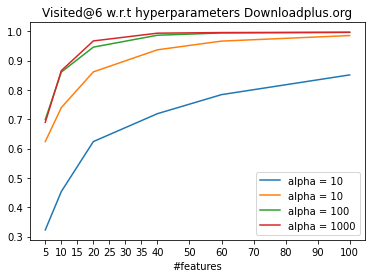

In [24]:
plt.plot(factors[:6], visited6s[:6], label='alpha = 10')
plt.plot(factors[6:12], visited6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], visited6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], visited6s[18:24], label='alpha = 1000')
plt.title("Visited@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'visited@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

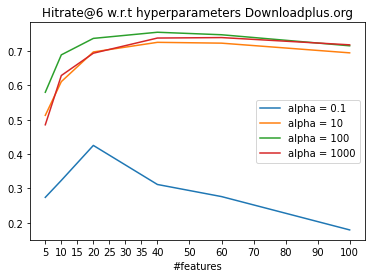

In [25]:
plt.plot(factors[:6], hitRate6s[:6], label='alpha = 0.1')
plt.plot(factors[6:12], hitRate6s[6:12], label='alpha = 10')
plt.plot(factors[12:18], hitRate6s[12:18], label='alpha = 100')
plt.plot(factors[18:24], hitRate6s[18:24], label='alpha = 1000')
plt.title("Hitrate@6 w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'hitrate@6_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

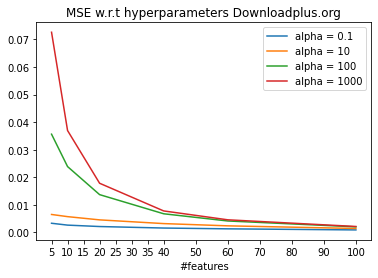

In [26]:
plt.plot(factors[:6], MSEs[:6], label='alpha = 0.1')
plt.plot(factors[6:12], MSEs[6:12], label='alpha = 10')
plt.plot(factors[12:18], MSEs[12:18], label='alpha = 100')
plt.plot(factors[18:24], MSEs[18:24], label='alpha = 1000')
plt.title("MSE w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'MSE_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

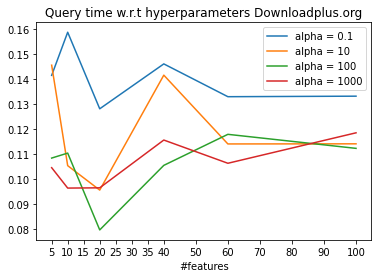

In [27]:
plt.plot(factors[:6], qTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], qTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], qTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], qTime[18:24], label='alpha = 1000')
plt.title("Query time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'querytime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)

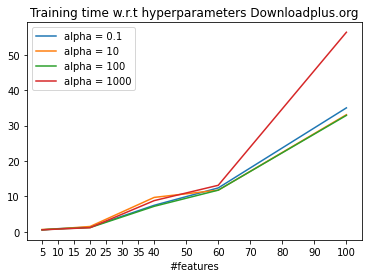

In [28]:
plt.plot(factors[:6], trainingTime[:6], label='alpha = 0.1')
plt.plot(factors[6:12], trainingTime[6:12], label='alpha = 10')
plt.plot(factors[12:18], trainingTime[12:18], label='alpha = 100')
plt.plot(factors[18:24], trainingTime[18:24], label='alpha = 1000')
plt.title("Training time w.r.t hyperparameters " + WEB_SITE_NAME)
plt.xlabel('#features')
plt.xticks([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
plt.legend()
plt.savefig(RESULTS + 'trainingtime_hyperparameters_' + WEB_SITE_NAME + '.png', dpi=400)